<a href="https://colab.research.google.com/github/AryaPratamaPutra-10/Analyst-Uang/blob/main/Selamat_Datang_di_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryapratamaputra10","key":"95340623c73554e9a82c2177872296e0"}'}

In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!kaggle datasets download
import os
import zipfile

# Pastikan Kaggle API Key sudah terkonfigurasi
!mkdir -p ~/.kaggle
!cp /path/to/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Tentukan dataset Kaggle dan tujuan
dataset_name = "yunhann/indonesian-rupiah-emission-2022-real-and-fake"
output_dir = "/content/rupiah-real-fake-dataset"

# Unduh dataset
!kaggle datasets download -d {dataset_name} -p /content

# Cari file ZIP yang sesuai
zip_file = f"/content/{dataset_name.split('/')[-1]}.zip"

# Ekstrak file ZIP ke folder tujuan
if os.path.exists(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Dataset berhasil diekstrak ke: {output_dir}")

    # Hapus file ZIP untuk menghemat ruang
    os.remove(zip_file)
else:
    print("File ZIP tidak ditemukan!")


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 63, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1569, in dataset_download_cli
    owner_slug, dataset_slug, _ = self.split_dataset_string(dataset)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 4162, in split_dataset_string
    if '/' in dataset:
       ^^^^^^^^^^^^^^
TypeError: argument of type 'NoneType' is not iterable
cp: cannot stat '/path/to/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/yunhann/indonesian-rupiah-emission-2022-real-and-fake
L

Labelling Data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "/content/rupiah-real-fake-dataset"


# Buat objek ImageDataGenerator untuk preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi pixel (0-1)
    validation_split=0.1  # 10% data untuk validasi
)


train_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset",  # Arahkan langsung ke "dataset"
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)




train_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

label_mapping = {
    "uang 100 asli": 0,
    "uang 100 palsu": 1,
    "uang 50 asli": 2,
    "uang 50 palsu": 3
}


print("Classes:", train_generator.class_indices)


Found 198 images belonging to 4 classes.
Found 22 images belonging to 4 classes.
Found 220 images belonging to 4 classes.
Classes: {'uang100asli': 0, 'uang100palsu': 1, 'uang50asli': 2, 'uang50palsu': 3}


In [9]:
import os
import shutil
import random

# Path asal dataset
dataset_path = "rupiah-real-fake-dataset/dataset"

# Path tujuan setelah dipisah
output_path = "data"
train_path = os.path.join(output_path, "train")
val_path = os.path.join(output_path, "val")

# Pastikan direktori tujuan ada
for path in [train_path, val_path]:
    for category in ["asli", "palsu"]:
        os.makedirs(os.path.join(path, category), exist_ok=True)

# Mapping folder ke kategori (asli/palsu)
category_map = {
    "uang100asli": "asli",
    "uang50asli": "asli",
    "uang100palsu": "palsu",
    "uang50palsu": "palsu"
}

# Fungsi untuk membagi dataset
def split_data(source_folder, dest_train, dest_val, split_ratio=0.2):
    images = os.listdir(source_folder)
    random.shuffle(images)  # Acak urutan gambar

    # Hitung jumlah untuk validasi
    split_idx = int(len(images) * split_ratio)

    for i, img in enumerate(images):
        src = os.path.join(source_folder, img)

        # Tentukan folder tujuan (train atau val)
        if i < split_idx:
            dest = os.path.join(dest_val, img)
        else:
            dest = os.path.join(dest_train, img)

        shutil.copy2(src, dest)  # Copy file

# Proses pemisahan dataset
for folder, category in category_map.items():
    source_folder = os.path.join(dataset_path, folder)

    train_dest = os.path.join(train_path, category)
    val_dest = os.path.join(val_path, category)

    split_data(source_folder, train_dest, val_dest)

print("✅ Dataset berhasil dipisahkan!")


✅ Dataset berhasil dipisahkan!


In [10]:
import os

print("Kelas di Training Set:", os.listdir(train_path))
print("Kelas di Validation Set:", os.listdir(val_path))


Kelas di Training Set: ['palsu', 'asli']
Kelas di Validation Set: ['palsu', 'asli']


Make a Model with CNN

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense

# inisiasi model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(4, activation='softmax'),
    Dropout(0.6),
])

#compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



# Ubah layer terakhir agar sesuai dengan jumlah kelas (4)
# model.add(Dense(4, activation='softmax'))  # 4 neuron untuk 4 kelas


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │         346,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 439,364 (1.68 MB)

 Trainable params: 439,364 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

Analisis Model
Tiga lapisan konvolusi (Conv2D)

- Menggunakan filter 3x3 untuk mengekstrak fitur dari gambar uang.
Jumlah filter meningkat (32 → 64 → 128) untuk menangkap fitur yang lebih kompleks.
Tiga lapisan pooling (MaxPooling2D)

- Menggunakan ukuran 2x2 untuk mengurangi dimensi fitur secara bertahap.
Lapisan Flatten

- Mengubah fitur map menjadi vektor 1D agar bisa diinput ke lapisan dense.
Lapisan Dense (4 neuron, Softmax)

- Model memiliki 4 kelas untuk membedakan jenis uang (uang100asli, uang100palsu, uang50asli, uang50palsu).
Dropout (p=0.5)

- Mencegah overfitting dengan mengabaikan sebagian neuron saat training.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation untuk training set
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisasi pixel ke [0,1]
    rotation_range=30,       # Rotasi acak hingga 30 derajat
    width_shift_range=0.2,   # Geser horizontal hingga 20%
    height_shift_range=0.2,  # Geser vertikal hingga 20%
    shear_range=0.2,         # Transformasi shearing
    zoom_range=0.2,          # Zoom acak hingga 20%
    horizontal_flip=True,    # Flip horizontal
    fill_mode='nearest'      # Mengisi pixel yang hilang akibat augmentasi
)

# Untuk validation data, kita hanya normalisasi tanpa augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset dari direktori
train_generator = datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset",            # Path folder dataset training
    target_size=(224, 224),  # Ukuran gambar sesuai input model
    batch_size=32,
    class_mode='categorical' # Klasifikasi multi-kelas
)

val_generator = val_datagen.flow_from_directory(
    "/content/rupiah-real-fake-dataset/dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Pastikan model di-train dengan train_generator
epochs = 25
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)


Found 220 images belonging to 4 classes.
Found 220 images belonging to 4 classes.
Epoch 1/25


ValueError: Cannot take the length of shape with unknown rank.

Found 220 images belonging to 1 classes.
Found 220 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9031 - loss: 0.2515 - val_accuracy: 1.0000 - val_loss: 2.3893e-19
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 3.9493e-18 - val_accuracy: 1.0000 - val_loss: 3.1564e-25
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 3.6135e-20 - val_accuracy: 1.0000 - val_loss: 4.2193e-28
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 3.2206e-23 - val_accuracy: 1.0000 - val_loss: 1.3962e-29
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 5.6836e-21 - val_accuracy: 1.0000 - val_loss: 2.3690e-30
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 5.3719e-26 - val_accuracy: 1.0000 - val_loss: 9.4320e-31
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 1.4893e-25 - val_accuracy: 1.0000 - val_loss: 5.8650e-31
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 5.9700

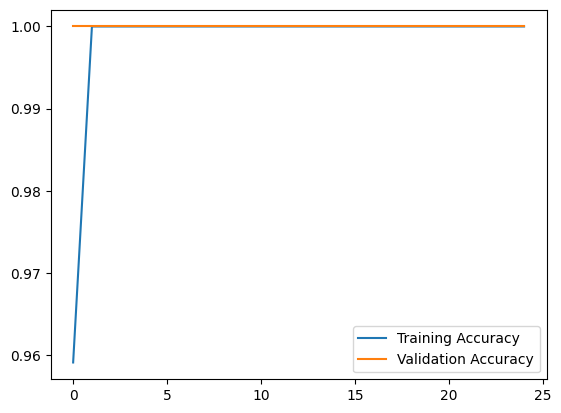

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2


# ===============================
# AUGMENTASI DATA
# ===============================
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi pixel (0-1)
    rotation_range=30,  # Rotasi acak 20 derajat
    width_shift_range=0.2,  # Geser horizontal
    height_shift_range=0.2,  # Geser vertikal
    shear_range=0.2,  # Distorsi bentuk
    zoom_range=0.3,  # Zoom in/out
    horizontal_flip=True,  # Flip horizontal
    brightness_range=[0.5, 1.5],  # Variasi kecerahan
    fill_mode='nearest'  # Isi pixel kosong
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Hanya normalisasi

# ===============================
# LOAD DATASET
# ===============================
train_generator = train_datagen.flow_from_directory(
    '/content/rupiah-real-fake-dataset',  # Pastikan path ini benar
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/rupiah-real-fake-dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# ===============================
# CEK DATASET ADA NAN/TIDAK
# ===============================
for batch, labels in train_generator:
    if np.isnan(batch).any():
        print("⚠️ Ada NaN di input data!")
    break

# ===============================
# MODEL CNN
# ===============================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularisasi untuk overfitting
    Dense(1, activation='sigmoid')  # Sigmoid karena binary classification
])

# transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Gunakan fitur pre-trained

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# ===============================
# KOMPILE MODEL
# ===============================
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradien untuk menghindari exploding
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# ===============================
# TRAIN MODEL
# ===============================
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

# ===============================
# SIMPAN MODEL
# ===============================
model.save("model_uang.h5")

# ===============================
# TES MODEL
# ===============================
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [8]:
import os
train_dir = "/content/rupiah-real-fake-dataset"
val_dir = "/content/rupiah-real-fake-dataset"

print("Kelas di Training Set:")
print(os.listdir(train_dir))  # Harus ada ['asli', 'palsu']

print("Kelas di Validation Set:")
print(os.listdir(val_dir))  # Harus ada ['asli', 'palsu']

Kelas di Training Set:
['dataset']
Kelas di Validation Set:
['dataset']


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
